In [2]:
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
import numpy as np
from resizeimage import resizeimage
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Globel Variables 
learning_rate=0.01
batch_size =16
epochs = 100
num_classes = 3
training_iters=1
weights = {
        'wc1': tf.get_variable('W0', shape=(3,3,1,32),initializer=tf.contrib.layers.xavier_initializer()),#Xavier Glorot and Yoshua Bengio (2010)
        'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
        'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
        'wd1': tf.get_variable('W3', shape=(32*32*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
        'out': tf.get_variable('W4', shape=(128,num_classes), initializer=tf.contrib.layers.xavier_initializer()), 
    }
biases = {
        'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
        'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
        'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
        'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
        'out': tf.get_variable('B4', shape=(num_classes), initializer=tf.contrib.layers.xavier_initializer()),
   }
parameters = {**weights,**biases}
x =tf.placeholder('float32',[None,256,256,1],name='input')
y =tf.placeholder('float32',[None,num_classes],name='output')


In [ ]:
#parameters = {**weights,**biases}

In [4]:
def make_BW(Inputpath,size=[256,256,1],DircName='Out'):    
    outputPath=[]
    for pat in Inputpath:
        if not os.path.exists(pat+'/'+DircName):
               os.mkdir(pat+'/'+DircName, 777 ) 
        outputPath.append(pat+'/'+DircName)  
    for i,path in  enumerate(Inputpath):
        listof = os.listdir(path)
        for img in listof:
                 if(img!=DircName): 
                     im = Image.open(path+'/'+img).convert('L')
                     cover =  resizeimage.resize_contain(im,size)
                     cover =cover.convert('L')
                     Image_array = np.array([np.array(cover)])
                     cover.save(outputPath[i]+'/'+img,'PNG')
    return outputPath

def DoAgument(Inputpath,DircName='Agu'):
    outputPath =[]
    outputPaths =[]
    count = 1
    for pat in Inputpath:
        outputPaths.append(pat+'/'+DircName)
        if not os.path.exists(pat+'/'+DircName):
               os.mkdir(pat+'/'+DircName, 777 ) 
    gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.05,height_shift_range=0.05,horizontal_flip=False)
    for k,input_path in enumerate(Inputpath):
        listof  =os.listdir(input_path)
        outputPath.append(input_path+'/'+DircName+'/random{}.png')
        for j in range(len(listof)):
            if(listof[j]!=DircName):
                # load image to array
                image = np.array([np.array(Image.open(input_path+'/'+listof[j]))])  
                # reshape to array rank 4
                image = image.reshape(1,256,256,1)
                # let's create infinite flow of images
                images_flow = gen.flow(image, batch_size=1)
                for i, new_images in enumerate(images_flow):
                    # we access only first image because of batch_size=1
                   
                    img = array_to_img(new_images[0]);
                    img.save(outputPath[k].format(j*10+i+1),"PNG")
                   # plt.imsave(arr=new_images[0],fname=output_path.format(j*10+i+1))
                    # new_image = Image.fromarray(new_images[0].reshape(256,256))
                    #plt.imsave(arr=new_images[0].reshape(256,256),fname=output_path.format(j*10+i+1),cmap='gray')
                    if i >= count:
                        break   
                        
    return outputPaths
                        
def GetLabeledData(ListOfDir):
    count =[]
    totel =0
    NoteData=[]
    for path in ListOfDir:
        listof = os.listdir(path)
        totel = totel+len(listof)
        count.append(totel)     
    print(totel)    
    Labels = np.zeros((totel,len(ListOfDir)))
    Data = np.zeros((totel,256*256))
    Last_index=0 
    for i,index in enumerate(count):
        print(Last_index,index)
        Labels[Last_index:index-1,i] = 1
        Labels[index-1,i] =1
        listof = os.listdir(ListOfDir[i])
        Data[Last_index:index,:] =  np.array([np.array(Image.open(ListOfDir[i]+'/'+lm)).flatten() for lm in listof])
        Last_index =index
    return Data,Labels

    


In [13]:
def RunPipeline(InputPath):
    paths = make_BW(InputPath)
    newPaths = DoAgument(paths)
    Images,Labels =GetLabeledData(newPaths)
    return Images,Labels

In [14]:
def TestDataLabels(Data,Labels,Index):
    f,ax = plt.subplots(1,len(Index),sharey=True,figsize=(50,50))
    for i,ind in enumerate(Index):
        ax[i].imshow(Data[ind].reshape(256,256),cmap='gray')
        ax[i].set_title(Labels[ind],fontsize=50)     
    plt.show();
    
def TestTrainPreprocess(Data,Labels,Test_size=0.3):
    Data = Data.astype('float32')
    Data = Data/ 255.
    Data = Data.reshape(-1,256,256,1)
    return train_test_split(Data,Labels,test_size=Test_size,random_state=341,shuffle=True)
   
def CreateTensorGraph():
    tf.reset_default_graph() 
    weights = {
        'wc1': tf.get_variable('W0', shape=(3,3,1,32),initializer=tf.contrib.layers.xavier_initializer()),#Xavier Glorot and Yoshua Bengio (2010)
        'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
        'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
        'wd1': tf.get_variable('W3', shape=(32*32*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
        'out': tf.get_variable('W4', shape=(128,num_classes), initializer=tf.contrib.layers.xavier_initializer()), 
    }
    biases = {
        'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
        'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
        'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
        'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
        'out': tf.get_variable('B4', shape=(num_classes), initializer=tf.contrib.layers.xavier_initializer()),
   }
    x =tf.placeholder('float32',[None,256,256,1],name='input')
    y =tf.placeholder('float32',[None,num_classes],name='output')
    parameters = {**weights,**biases}
    return weights,biases,x,y,parameters


    
def conv2d(x,w,b,strides=1):
    x = tf.nn.conv2d(x,w,strides=[1,strides,strides,1],padding='SAME')
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

def maxpool2d(x,k=2):
    return tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')



def conv_net(x, weights, biases):
    ###input 
    conv1 = conv2d(x,weights['wc1'],biases['bc1'])
    conv1 = maxpool2d(conv1,k=2)
    dropl =  tf.nn.dropout(conv1,0.75) 
    conv2 = conv2d(dropl,weights['wc2'],biases['bc2'])
    conv2 = maxpool2d(conv2,k=2)
    drop2 =  tf.nn.dropout(conv2,0.8)
    conv3 = conv2d(drop2,weights['wc3'],biases['bc3'])
    conv3 = maxpool2d(conv3,k=2)
    drop3 =  tf.nn.dropout(conv3,0.8)
    fc1   = tf.reshape(drop3,[-1,weights['wd1'].get_shape().as_list()[0]])
    fc1   = tf.add(tf.matmul(fc1,weights['wd1']),biases['bd1'])
    fc1   = tf.nn.relu(fc1)
    drop4 =  tf.nn.dropout(fc1 , 0.9) 
    out   = tf.add(tf.matmul(drop4,weights['out']),biases['out'])
    return out


        

In [15]:
def DoSomeCoolStuff(train_X,train_y,test_X,test_y,path="./tmp/model3.ckpt"):
   # weights,biases,x,y,parameters =CreateTensorGraph()
    pred = conv_net(x, weights, biases)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    init = tf.initialize_all_variables()
    tf.local_variables_initializer()
    saver = tf.train.Saver(parameters)
    with tf.Session() as sess:
        sess.run(init) 
        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []
        for i in range(training_iters):
            for batch in range(len(train_X)//batch_size):
                batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
                batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
                opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
                loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(i) + ", Loss= " + \
                          "{:.6f}".format(loss) + ", Training Accuracy= " + \
                          "{:.5f}".format(acc))
            print("Optimization Finished!")

            test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y: test_y})
            train_loss.append(loss)
            test_loss.append(valid_loss)
            train_accuracy.append(acc)
            test_accuracy.append(test_acc)
            print("Testing Accuracy:","{:.5f}".format(test_acc))
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./tmp/model3.ckpt")
        ##test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x:DatasetTest,y: LabelsTest})    
        ##print(test_acc,valid_loss)    
        
    return saver,save_path

In [16]:
def Run():
    path12 = "C:/Users/ma185280/Desktop/dataa/INR-100"
    path22 = "C:/Users/ma185280/Desktop/dataa/INR-500"
    path13 = "C:/Users/ma185280/Desktop/dataa/others"
    listofInput = [path12,path22,path13]
    Data,Labels = RunPipeline(listofInput)
    TestDataLabels(Data,Labels,[60,120,180,240])
    X_train, X_test, y_train, y_test=TestTrainPreprocess(Data,Labels)
    path = DoSomeCoolStuff(X_train,y_train,X_test,y_test)
    return path
    
    
    

612
0 152
152 292
292 612


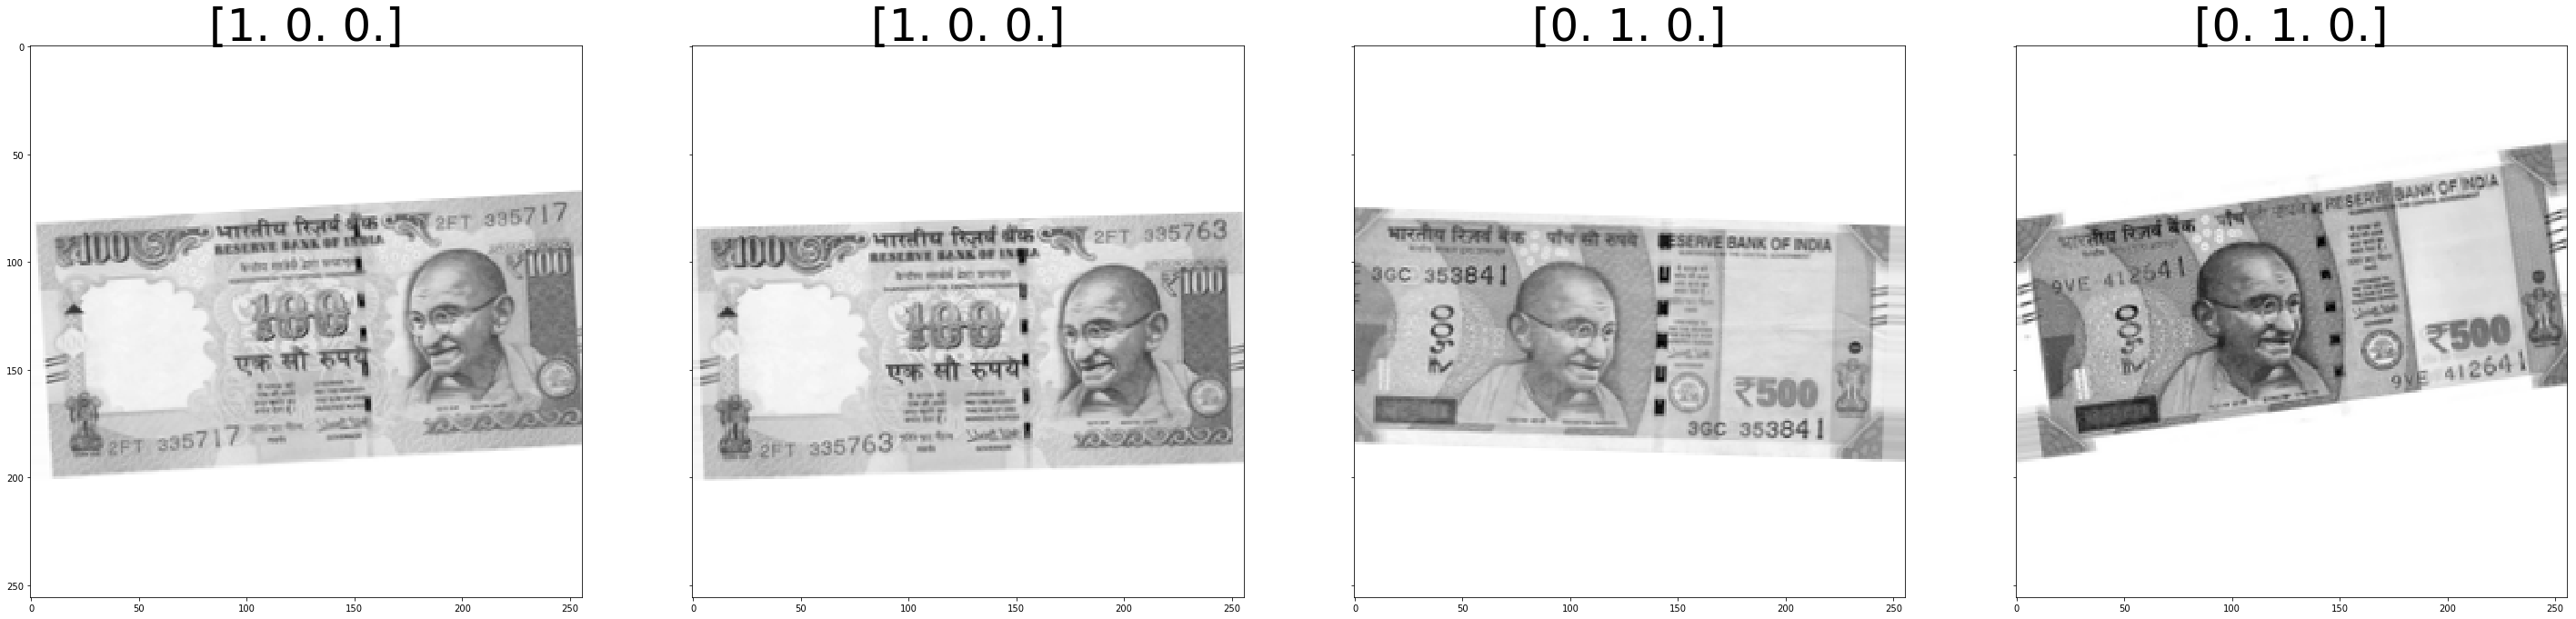

Iter 0, Loss= 1.030826, Training Accuracy= 0.43750
Optimization Finished!
Testing Accuracy: 0.38043


In [17]:
saver,save_path= Run()


In [10]:
path12Test = "C:/Users/ma185280/Desktop/dataa/Test_100"
path22Test = "C:/Users/ma185280/Desktop/dataa/Test_500"
path13Test = 'C:/Users/ma185280/Desktop/dataa/OthersTest'
InputPath = [path12Test,path22Test,path13Test]
DataTest,LabelsTest = GetLabeledData(InputPath)
DataTest = DataTest.astype('float32')
DataTest = DataTest/ 255.
DataTest = DataTest.reshape(-1,256,256,1)


110
0 41
41 67
67 110


In [18]:
#saver = tf.train.Saver()
#print(save_path)
# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess1:
   # saver = tf.train.Saver(parameters)
  # Restore variables from disk.
    saver.restore(sess1, "./tmp/model3.ckpt")
    pred = conv_net(x, weights, biases)

   # cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    init = tf.global_variables_initializer()
    
    print("Model restored.")
  # Check the values of the variables
   #pred = conv_net(DatasetTest, weights, biases)
  #correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(LabelsTest, 1))
  #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Accuracy :',sess1.run(accuracy,feed_dict={x:DataTest,y:LabelsTest}))
  

INFO:tensorflow:Restoring parameters from ./tmp/model3.ckpt
Model restored.
Accuracy : 0.42727274
